In [10]:
import numpy as np
from numpy.polynomial.legendre import legval
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt


def evaluate(points, components):
    """
    Evaluates the function represented by the ALS components at given points.

    Args:
        points (ndarray): Points where the function will be evaluated.
        components (list of ndarray): Tensor train components representing the function.

    Returns:
        ndarray: Evaluated function values at the input points.
    """
    d = len(components)
    leg_sups = np.sqrt(2 * np.arange(components[0].shape[1]) + 1)
    evaluated_legendre = legval(points, np.diag(leg_sups)).T

    result = np.einsum("mi,hij->mj", evaluated_legendre[0], components[0])

    for mode in range(1, d - 1):
        result = np.einsum(
            "mh,mi,hij->mj", result, evaluated_legendre[mode], components[mode]
        )

    return np.einsum("mh,mi,hij->m", result, evaluated_legendre[-1], components[-1])

In [11]:
def plot_results(df):
    # Get unique values of l_train
    l_train_values = df["l_train"].unique()

    # Plotting
    plt.figure(figsize=(15, 10))

    for l in l_train_values:
        subset = df[df["l_train"] == l]
        plt.plot(subset["N_SLM"], subset["SMSE SLM"], marker="o", label=f"l_train={l}")

        # Add reference line for mean SMSE FEM
        mean_fem = subset["SMSE FEM"].mean()
        plt.axhline(
            y=mean_fem,
            linestyle="--",
            linewidth=1,
            label=f"l_={l})",
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("N_SLM")
    plt.ylabel("SMSE SLM")
    plt.title("Log-Log Plot of SMSE SLM vs N_SLM for Different l_train")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

In [12]:
def main():

    # later via argparse
    components_file = "data/2025-03-15_12-01-39_solution_components.npz"
    samples_file = "data/2025-03-15_12-01-39_samples.npz"
    errors_file = "errors_single.csv"

    # Load FEM sample data
    with np.load(samples_file) as sample_data:
        points_test = sample_data["points_test"]
        values_test = sample_data["values_test"]
        l_test = sample_data["levels"][-1].item()
        N_test, d_test = points_test.shape

        points_train = sample_data["points_train"]
        values_train = sample_data["values_train"]
        levels_train = sample_data["levels"][:-1].tolist()
        N_fem, d_train = points_train.shape

    # Load the tensor trains computed with SALS (Single Level Method)
    with np.load(components_file) as components_data:
        components_dict = defaultdict(lambda: defaultdict(lambda: [None] * d_train))

        for key in components_data.keys():
            try:
                l, N, mode = map(
                    int, key.split("-")
                )  # Parse the key format "{l}-{N}-{mode}"
                if mode >= d_train:
                    raise ValueError(
                        f"Mode {mode} exceeds expected d_train size {d_train}"
                    )
                components_dict[l][N][mode] = components_data[key]
            except ValueError as e:
                print(f"Skipping invalid key '{key}': {e}")

    # Convert defaultdict to standard dict for immutability
    components_dict = {
        l: dict(N_fem_values) for l, N_fem_values in components_dict.items()
    }

    # Load the CSV file
    df = pd.read_csv(errors_file)
    # Columns l_train,d_train,l_test,d_test,N_SLM,N_test,SMSE SLM,N_FEM,SMSE FEM

    for l in components_dict.keys():
        l_idx = levels_train.index(l)

        for N in components_dict[l].keys():
            # Initialize the dictionary to store the errors
            error_dict = {
                "l_train": l,
                "d_train": d_train,
                "l_test": l_test,
                "d_test": d_test,
                "N_SLM": N,
                "N_test": N_test,
                "N_FEM": N_fem,
            }

            components = components_dict[l][N]
            values_pred = evaluate(points_test, components)

            error_dict["SMSE SLM"] = np.sqrt(
                np.mean((values_test[-1] - values_pred) ** 2)
            )

            error_dict["SMSE FEM"] = np.sqrt(
                np.mean((values_train[-1] - values_train[l_idx]) ** 2)
            )

            df = pd.concat([df, pd.DataFrame([error_dict])], ignore_index=True)

            df.to_csv(errors_file)
    plot_results(df)

    return df

/var/folders/2_/_k3ltqzn0h77f4y_m29096w499_8fg/T/ipykernel_2291/808509518.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([error_dict])], ignore_index=True)


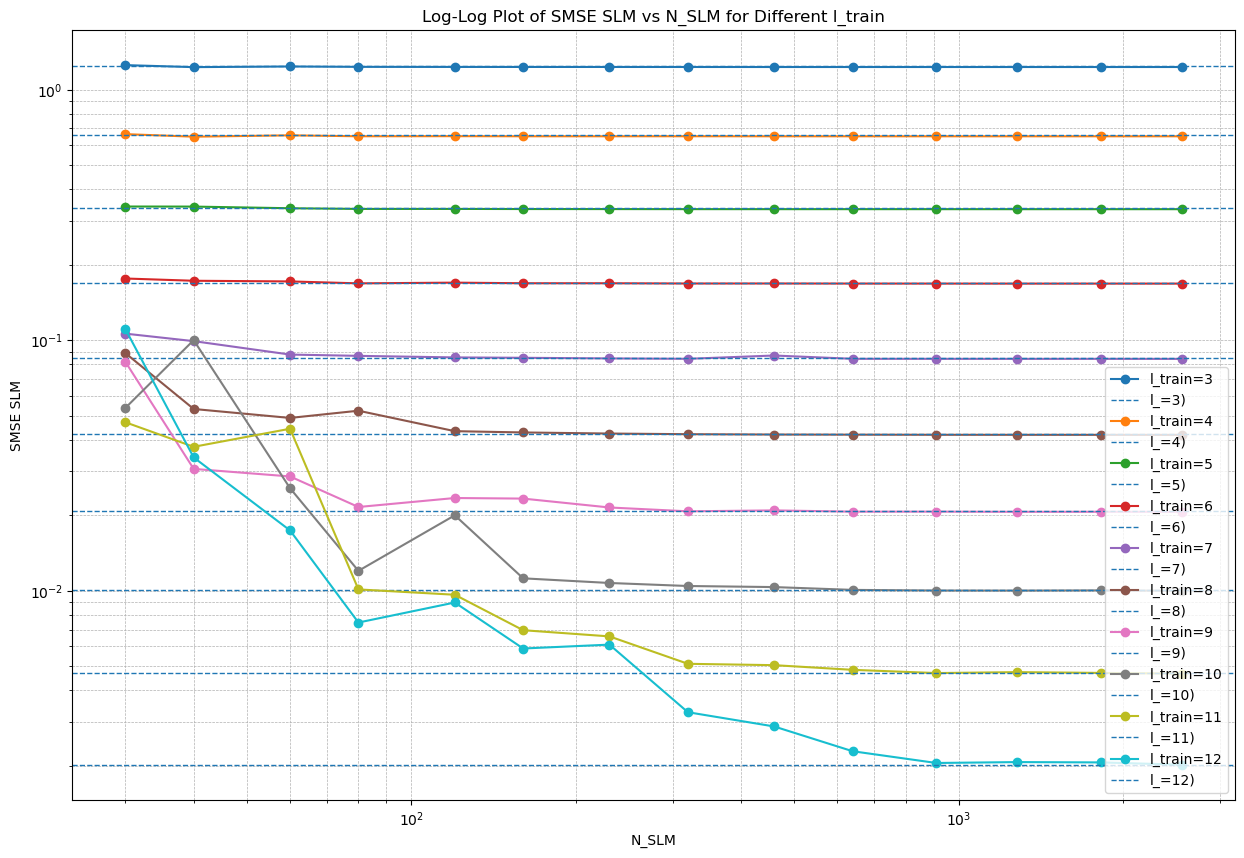

,l_train,d_train,l_test,d_test,N_SLM,N_test,SMSE SLM,N_FEM,SMSE FEM
0,3,6,14,6,30,1000,1.252733,10000,1.240348
1,3,6,14,6,40,1000,1.229841,10000,1.240348
2,3,6,14,6,60,1000,1.237252,10000,1.240348
3,3,6,14,6,80,1000,1.233035,10000,1.240348
4,3,6,14,6,120,1000,1.232133,10000,1.240348
...,...,...,...,...,...,...,...,...,...
135,12,6,14,6,640,1000,0.002288,10000,0.002014
136,12,6,14,6,910,1000,0.002054,10000,0.002014
137,12,6,14,6,1280,1000,0.002071,10000,0.002014
138,12,6,14,6,1820,1000,0.002065,10000,0.002014


In [13]:
main()

In [14]:
data = np.load("test.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'test.npz'